![data cube logo](https://static.wixstatic.com/media/8959d6_a13dc7ece5be4678af57c8f7c1667734~mv2.png/v1/fill/w_279,h_177,al_c,q_85,usm_0.66_1.00_0.01,enc_auto/VSDC_DataCubeSplash_6Partner_edited.png)
# Reprojecting datacube and raster data

 - Sign up to the VA Datacube (INSERT LINK) to run this notebook interactively from a browser
 - <b>Compatibility</b>: Notebook currently compatible with both the NCI and DEA Sandbox environments    

 - <b>Products used</b>:
    
    products....
 
 - <b>Special requirements:</b> An optional description of any special requirements, e.g. If running on the NCI, ensure that
    module load otps is run prior to launching this notebook
 
 - <b>Prerequisites:</b> An <i>optional</i> list of any notebooks that should be run or content that should be understood
    prior to launching this notebook
 
 - <b>Notebook Use:</b> If you would like to modify and save this notebook, please copy and paste it into your own folder on the data cube, here is how:

 


## Background


An <i>optional</i> overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Australia. For Beginners_Guide or Frequently_Used_Code notebooks, this may include information about why the particular technique or approach is useful or required. If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. Dhu et al. 2017).

## Description

A <i>compulsory</i> description of the notebook, including a brief overview of how Digital Earth Australia helps to address the problem set out above. It can be good to include a run-down of the tools/methods that will be demonstrated in the notebook:

1. First we do this
2. Then we do this
3. Finally we do this

---------------------------------------------------------------------------------------------------------------------------

## Getting started


To run this analysis, run all the cells in the notebook, starting with the “Load packages” cell.

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. Begin with any iPython magic commands, followed by standard Python packages, then any additional functionality you need from the Scripts directory.

In [47]:
import datacube
import xarray as xr
import matplotlib.pyplot as plt
from odc.algo import xr_reproject
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.masking import mask_invalid_data
from matplotlib.colors import LightSource

import sys
# from deafrica_tools
from deafrica_tools.plotting import rgb

### Connect to the datacube

Connect to the datacube so we can access DEA data. The app parameter is a unique name for the analysis which is based on the notebook file name

In [2]:
dc = datacube.Datacube()

### Analysis parameters
An optional section to inform the user of any parameters they'll need to configure to run the notebook:
 - param_name_1: Simple description (e.g. example_value). Advice about appropriate values to choose for this parameter.
 - param_name_2: Simple description (e.g. example_value). Advice about appropriate values to choose for this parameter.

 

In [ ]:
param_name_1 = 'example_value'
param_name_2 = 'example_value'

## Loading and reprojecting datacube data to match a raster¶

# Load a raster file

First we load a GeoTIFF raster from file using `xr.open_rasterio`. 

The example below is from this [Microsoft website](https://planetarycomputer.microsoft.com/dataset/nasadem) and is in the WGS 84 (`EPSG:4326`) coordinate reference system.


In [3]:
# Load the raster 
data = dc.load(product="nasadem", 
               resolution=(-0.001, 0.001), 
               lon=(-77,-76), lat=(36.5,37.5))

data

/opt/tljh/user/lib/python3.9/site-packages/datacube/drivers/postgres/_api.py:564: SAWarning: Class Float8Range will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  return self._connection.execute(select_query)


<xarray.Dataset>
Dimensions:      (time: 1, latitude: 1000, longitude: 1000)
Coordinates:
  * time         (time) datetime64[ns] 2000-02-20
  * latitude     (latitude) float64 37.5 37.5 37.5 37.5 ... 36.5 36.5 36.5 36.5
  * longitude    (longitude) float64 -77.0 -77.0 -77.0 ... -76.0 -76.0 -76.0
    spatial_ref  int32 4326
Data variables:
    elevation    (time, latitude, longitude) int16 28 33 25 27 36 ... 0 0 0 0 0
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

If we plot our loaded raster, we can see Hampton Roads and the surrounding coastal zone of southern Virginia. In the dark areas lie areas of low elevation and nearby areas of higher elevation as brighter pixels. 

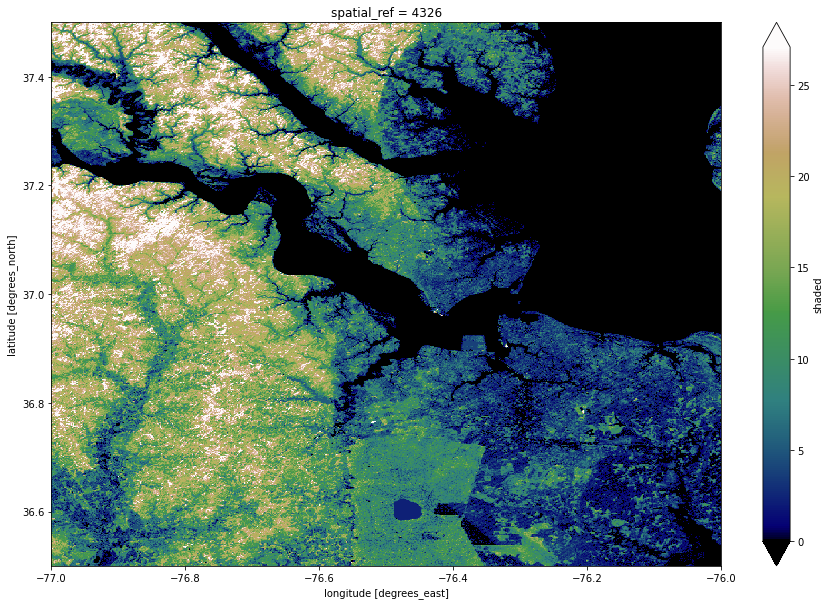

In [4]:
#Plot it

# Sample elevation array
elevation = data.elevation.isel(time=0).values

# Create hillsahde based on the array
ls = LightSource(azdeg=315, altdeg=45)
dyx = 10
shade = ls.hillshade(elevation, vert_exag=0.5, dx=dyx, dy=dyx, fraction=1.0)

# Modify the original elevation data to include shade
data['shaded'] = (['latitude', 'longitude'], elevation * shade)

# Plot using bilinear interpolation to remove artefacts
data.shaded.plot(size=10, robust=True, cmap="gist_earth")

### GeoBox objects

Now we have loaded our raster dataset, we can inspect its `GeoBox` object that we will use to allow us to reproject data. The `GeoBox` can be accessed using the `.geobox` method. It includes a set of information that together completely define the spatial grid of our data: * The width (e.g. `1000`) and height (e.g. `1000`) of our data in pixels; an Affine object which defines the spatial resolution (e.g. `0.0009999999999999953` and `-0.0010000000000000024`) and spatial position (e.g. `-77.0` and `37.5`) of our data; and, the coordinate reference system of our data (e.g. `+init=epsg:4326`)

<b>Note:</b> For more information about `GeoBox` objects and a complete list of their methods, refer to the [datacube documentation](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.utils.geometry.GeoBox.html#).

In [11]:
# call the geobox
data.geobox

GeoBox(1000, 1000, Affine(0.0009999999999999953, 0.0, -77.0,
       0.0, -0.0010000000000000024, 37.5), GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]])

### Load and reproject datacube data

We can now use datacube to load and reproject satellite data to exactly match the coordinate reference system and resolution of our raster data. By specifying `like=raster.geobox`, we can load datacube data that will be reprojected to match the spatial grid of our raster.

In [24]:
# Load and reproject data from datacube
ds = dc.load(product="s2_l2a",
             measurements=["red", "green", "blue"], #bands 
             time=("2019-06-15", "2019-06-15"), #when the images took place
             like=data.geobox, #here you can make sure other data cube products line up with another's geobox and extent, as explored above
             resampling="nearest", #resampling method
             group_by="solar_day")

When we plot the result, it should appear similarly pixelated to the low resolution raster we loaded above:

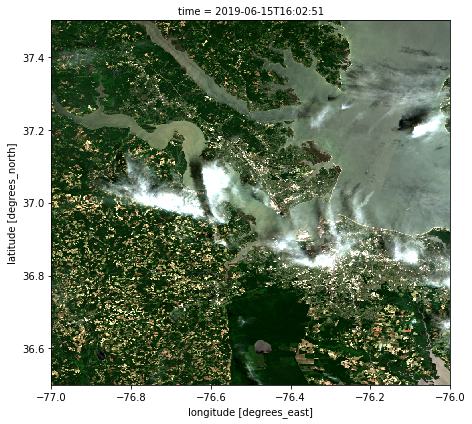

In [25]:
rgb(ds, col='time')

We can also directly compare the geobox of the two datasets to verify they share the same spatial grid:

In [26]:
ds.geobox == data.geobox

True

Now that our two datasets share the same spatial grid, we can use our raster as a mask. For example, we can mask out all satellite pixels except those located on hills (e.g. greater than 600 m elevation):

In [52]:
?where

Object `where` not found.


In [53]:

# Identify hilly areas
is_hilly = data > 10

print(is_hilly)

print(ds)

# # Apply mask to set non-hilly areas to `NaN`
ds_masked = ds.where(is_hilly)

print(ds_masked)

# Plot the masked data
#rgb(ds_masked,
#    col="time")


<xarray.Dataset>
Dimensions:      (time: 1, latitude: 1000, longitude: 1000)
Coordinates:
  * time         (time) datetime64[ns] 2000-02-20
  * latitude     (latitude) float64 37.5 37.5 37.5 37.5 ... 36.5 36.5 36.5 36.5
  * longitude    (longitude) float64 -77.0 -77.0 -77.0 ... -76.0 -76.0 -76.0
    spatial_ref  int32 4326
Data variables:
    elevation    (time, latitude, longitude) bool True True True ... False False
    shaded       (latitude, longitude) bool True True True ... False False False
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref
<xarray.Dataset>
Dimensions:      (time: 1, latitude: 1000, longitude: 1000)
Coordinates:
  * time         (time) datetime64[ns] 2019-06-15T16:02:51
  * latitude     (latitude) float64 37.5 37.5 37.5 37.5 ... 36.5 36.5 36.5 36.5
  * longitude    (longitude) float64 -77.0 -77.0 -77.0 ... -76.0 -76.0 -76.0
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) uint16 231 226 229 ... 1386 14

## Heading 2

Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.


In [1]:
# Use code comments for low-level documentation of code
c = 3

## Additional information

<b>License:</b> The code in this notebook is licensed under the Apache License, Version 2.0. Digital Earth Australia data is licensed under the Creative Commons by Attribution 4.0 license.

<b>Contact:</b> If you need assistance, please post a question on the Open Data Cube Slack channel or on the GIS Stack Exchange using the open-data-cube tag (you can view previously asked questions here). If you would like to report an issue with this notebook, you can file one on Github.

<b>Last modified:</b> May 2020

<b>Compatible datacube version:</b>

In [ ]:
print(datacube.__version__)

## Tags 
Browse all available tags on the VA Data Cube User Guide's Tags Index 